In [ ]:
# Discard the output of this cell.
%%capture

!pip install timm

In [ ]:
# Discard the output of this cell.
%%capture

!apt-get install unrar
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar
!rm -fr UCF50.rar

In [3]:
import matplotlib.pyplot as plt
import os
import torch
import timm
import numpy as np
from torch import nn
from tqdm import tqdm
from glob import glob

Reproducibility

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

## Dataset

In [4]:
PATH_DATASET_DIR = "/kaggle/working/UCF50"
HEIGHT, WIDTH = 240, 320
SEQUENCE_LENGTH = 20

videos = glob(f"{PATH_DATASET_DIR}/**/*.avi")
labels = [path.replace(f"{PATH_DATASET_DIR}/", "") for path in glob(f"{PATH_DATASET_DIR}/**")]

In [5]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
from torch.utils.data import Dataset
import cv2

class VideoDataset(Dataset):
    
    def __init__(self, video_paths, transform=None, num_videos=None, num_frames=None):
        self.video_paths = video_paths
        self.transform = transform
        self.lab2idx = {}
        
        if num_videos is not None:
            labels = set([path.split("/")[-2] for path in video_paths])
            self.lab2idx = { w : i for i, w in enumerate(labels) } 
            buffer = []
            for label in labels:
                videos = []
                for path in video_paths:
                    if label in path:
                        videos.append(path)
                videos = np.random.choice(videos, num_videos)
                buffer.extend(videos)
            self.paths = buffer
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        video_path = self.paths[idx]
        label = video_path.split("/")[-2]
        frames = self.read_video(video_path)
        if self.transform:
            frames = torch.stack([self.transform(frame) for frame in frames])
        else:
            frames = torch.stack(frames)
        return frames, self.lab2idx[label]
    
    def read_video(self, video_path):
        
        cap = cv2.VideoCapture(video_path)
        frames = []
        frames_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        window = max(int(frames_count/SEQUENCE_LENGTH), 1)
        
        for i in range(SEQUENCE_LENGTH):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i * window)
            ret, frame = cap.read()
            if not ret:
                break
            fixed_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
            
        cap.release()
        return np.array(frames)

In [7]:
dataset = VideoDataset(videos, transform, 100)

In [8]:
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

### Train and test split

In [ ]:
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

### Transform and train dataloader

In [ ]:
batch_size = 4
num_workers = os.cpu_count()
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle = True, batch_size = batch_size, drop_last = True, num_workers = num_workers)
val_dataloader = torch.utils.data.DataLoader(val_dataset, shuffle = True, batch_size = batch_size, drop_last = True, num_workers = num_workers)

### Transform and test data loader

In [ ]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, drop_last = True, num_workers = num_workers)

## Necessary functions

### Evaluate function

In [ ]:
def evaluate(model, val_data, loss_fn, weights = None, device = 'cpu', verbose = 0):
    
    if (device == 'gpu' or device == 'cuda') and torch.cuda.is_available():
        device = torch.device('cuda')
    elif isinstance(device, torch.device): 
        device = device
    else: 
        device = torch.device('cpu')
    
    model = model.to(device)

    if weights:
        model.load_state_dict(torch.load(weights))
    
    with torch.no_grad():
        model.eval()
        val_correct = 0
        val_total = len(val_data)*val_data.batch_size
        running_loss = 0.
        if verbose == 1:
            val_data = tqdm(val_data, desc = 'Evaluate: ', ncols = 100)
        for data_batch, label_batch in val_data:
            
            data_batch, label_batch = data_batch.to(device), label_batch.to(device)
            output_batch = model(data_batch.reshape([-1, 3, 20, 240, 240]))
            loss = loss_fn(output_batch, label_batch.long())
            running_loss += loss.item()

            _, predicted_labels = torch.max(output_batch.data, dim = 1)

            val_correct += (label_batch == predicted_labels).sum().item()
        val_loss = running_loss/len(val_data)
        val_acc = val_correct/val_total
        return val_loss, val_acc


### Train function

In [ ]:
def train(model, train_data, val_data, loss_fn, optimizer, epochs, save_last_weights_path = None,
          save_best_weights_path = None, freeze = False, steps_per_epoch = None,
          device = 'cpu', scheduler = None):

    if (device == 'gpu' or device == 'cuda') and torch.cuda.is_available():
        device = torch.device('cuda')
    elif isinstance(device, torch.device): 
        device = device
    else: 
        device = torch.device('cpu')        

    if save_best_weights_path: 
        best_loss, _ = evaluate(model, val_data, device = device, loss_fn = loss_fn, verbose = 1)  

    if steps_per_epoch is None: 
        steps_per_epoch = len(train_data)

    num_steps = len(train_data)
    iterator = iter(train_data)
    count_steps = 1    
    
    ## History
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_loss': []
    }
        
    # add model to device
    model = model.to(device)
    
    ############################### Train and Val ##########################################
    for epoch in range(1, epochs + 1):

        running_loss = 0.
        train_correct = 0
        train_total = steps_per_epoch*train_data.batch_size
        
        model.train()
        
        for step in tqdm(range(steps_per_epoch), desc = f'epoch: {epoch}/{epochs}: ', ncols = 100): 
            
            img_batch, label_batch = next(iterator)
            img_batch, label_batch = img_batch.to(device), label_batch.to(device)

            optimizer.zero_grad()

            output_batch = model(img_batch.reshape([-1, 3, 20, 240, 240]))

            loss = loss_fn(output_batch, label_batch.long())
            loss.backward()
            optimizer.step()

            _, predicted_labels = torch.max(output_batch.data, dim = 1)
            train_correct += (label_batch == predicted_labels).sum().item()
            running_loss += loss.item()
                
            if count_steps == num_steps:
                count_steps = 0
                iterator = iter(train_data)
            count_steps += 1
            
        train_loss = running_loss / steps_per_epoch
        train_accuracy = train_correct/train_total
        
        if scheduler:
            scheduler.step(train_loss)
        
        history['train_loss'].append(float(train_loss))
        history['train_acc'].append(float(train_accuracy))
        
        if val_data is not None: 
            val_loss, val_acc = evaluate(model, val_data, device = device, loss_fn = loss_fn)
            print(f'epoch: {epoch}, train_accuracy: {train_accuracy: .2f}, loss: {train_loss: .3f}, val_accuracy: {val_acc: .2f}, val_loss: {val_loss:.3f}')

            if save_best_weights_path:
                if val_loss < best_loss:
                    best_loss = val_loss
                    torch.save(model.state_dict(), save_best_weights_path)
                    print(f'Saved successfully best weights to:', save_best_weights_path)
            history['val_loss'].append(float(val_loss))
            history['val_acc'].append(float(val_acc))
        else:
            print(f'epoch: {epoch}, train_accuracy: {train_accuracy: .2f}, loss: {train_loss: .3f}')
    if save_last_weights_path:  
        torch.save(model.state_dict(), save_last_weights_path)
        print(f'Saved successfully last weights to:', save_last_weights_path)
    return model, history


### Visualize history

In [ ]:
def visualize_history(history, metrics = ['acc', 'loss']):   
    
    if 'acc' in metrics:
        plt.figure(figsize = (10,6))
        plt.subplot(121)
        plt.plot(range(1, len(history['train_acc']) + 1), history['train_acc'], label = 'train_acc', c = 'r')
        plt.plot(range(1, len(history['val_acc']) + 1), history['val_acc'], label = 'val_acc', c = 'g')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    if 'loss' in metrics:
        plt.subplot(122)
        plt.plot(range(1, len(history['train_loss']) + 1), history['train_loss'], label = 'train_loss', c = 'r')
        plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'], label = 'val_loss', c = 'g')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

# Model 
![](https://www.researchgate.net/publication/334729124/figure/fig2/AS:785436423241728@1564274044276/Conv-LSTM-neural-network-structure-is-composed-of-three-main-functional-layers.png)

In [13]:
class ClassificationModel(nn.Module):
    def __init__(self, num_classes, hidden_size, num_lstm_layers = 2, backbone_name = 'resnet101'):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained = True, features_only = True)
        self.adap = nn.AdaptiveAvgPool2d((2,2))
        
        self.lstm = nn.LSTM(2048, hidden_size, num_lstm_layers, batch_first = True)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        'x: batch, num_frames, channels, height, width'
        batch, num_frames, channels, height, width = x.shape
        
        x = torch.reshape(x, (-1, *x.shape[2:]))
        
        x1,x2,x3,x4,x5 = self.backbone(x)
        
        x = self.adap(x3)
        
        x = nn.Flatten()(x)
        
        x = torch.reshape(x, (batch, num_frames, -1))
        
        x, (h_n, c_n) = self.lstm(x)
        
        x = h_n[-1, ...]
        
        x = self.fc(x)
        
        return x

### Parameters

In [15]:
mode = 'train'
last_weights = 'last_weights.pt'
best_weights = 'best_weights.pt'

num_classes = 50
batch_size = 4
num_frames = SEQUENCE_LENGTH
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_workers = os.cpu_count()
hidden_size = 128
num_lstm_layers = 2

### Create model

In [ ]:
model = ClassificationModel(num_classes = num_classes, hidden_size = hidden_size, 
                            num_lstm_layers = num_lstm_layers, backbone_name = 'resnet101')

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, mode = 'min', patience = 3, verbose = 1)

## Train model

In [18]:
model, history = train(model, train_dataloader, val_dataloader, loss_fn, optimizer, epochs = 50,
              save_last_weights_path = last_weights, save_best_weights_path = best_weights,
              device = device, scheduler = scheduler)


epoch: 1/50: 100%|████████████████████████████████████████████████| 875/875 [06:43<00:00,  2.17it/s]


epoch: 1, train_accuracy:  0.04, loss:  3.878, val_accuracy:  0.07, val_loss: 3.742
Saved successfully best weights to: best_weights.pt


epoch: 2/50: 100%|████████████████████████████████████████████████| 875/875 [06:41<00:00,  2.18it/s]


epoch: 2, train_accuracy:  0.09, loss:  3.538, val_accuracy:  0.11, val_loss: 3.316
Saved successfully best weights to: best_weights.pt


epoch: 3/50: 100%|████████████████████████████████████████████████| 875/875 [06:42<00:00,  2.18it/s]


epoch: 3, train_accuracy:  0.15, loss:  3.209, val_accuracy:  0.18, val_loss: 3.056
Saved successfully best weights to: best_weights.pt


epoch: 4/50: 100%|████████████████████████████████████████████████| 875/875 [06:42<00:00,  2.17it/s]


epoch: 4, train_accuracy:  0.21, loss:  2.952, val_accuracy:  0.23, val_loss: 2.847
Saved successfully best weights to: best_weights.pt


epoch: 5/50: 100%|████████████████████████████████████████████████| 875/875 [06:42<00:00,  2.17it/s]


epoch: 5, train_accuracy:  0.26, loss:  2.740, val_accuracy:  0.25, val_loss: 2.799
Saved successfully best weights to: best_weights.pt


epoch: 6/50: 100%|████████████████████████████████████████████████| 875/875 [06:42<00:00,  2.17it/s]


epoch: 6, train_accuracy:  0.31, loss:  2.566, val_accuracy:  0.31, val_loss: 2.508
Saved successfully best weights to: best_weights.pt


epoch: 7/50: 100%|████████████████████████████████████████████████| 875/875 [06:43<00:00,  2.17it/s]


epoch: 7, train_accuracy:  0.34, loss:  2.410, val_accuracy:  0.33, val_loss: 2.402
Saved successfully best weights to: best_weights.pt


epoch: 8/50: 100%|████████████████████████████████████████████████| 875/875 [06:44<00:00,  2.17it/s]


epoch: 8, train_accuracy:  0.37, loss:  2.258, val_accuracy:  0.36, val_loss: 2.386
Saved successfully best weights to: best_weights.pt


epoch: 9/50: 100%|████████████████████████████████████████████████| 875/875 [06:44<00:00,  2.16it/s]


epoch: 9, train_accuracy:  0.42, loss:  2.136, val_accuracy:  0.39, val_loss: 2.246
Saved successfully best weights to: best_weights.pt


epoch: 10/50: 100%|███████████████████████████████████████████████| 875/875 [06:43<00:00,  2.17it/s]


epoch: 10, train_accuracy:  0.43, loss:  2.046, val_accuracy:  0.43, val_loss: 2.081
Saved successfully best weights to: best_weights.pt


epoch: 11/50: 100%|███████████████████████████████████████████████| 875/875 [06:45<00:00,  2.16it/s]


epoch: 11, train_accuracy:  0.47, loss:  1.897, val_accuracy:  0.47, val_loss: 2.007
Saved successfully best weights to: best_weights.pt


epoch: 12/50: 100%|███████████████████████████████████████████████| 875/875 [06:44<00:00,  2.16it/s]


epoch: 12, train_accuracy:  0.49, loss:  1.813, val_accuracy:  0.44, val_loss: 2.060


epoch: 13/50: 100%|███████████████████████████████████████████████| 875/875 [06:44<00:00,  2.16it/s]


epoch: 13, train_accuracy:  0.52, loss:  1.703, val_accuracy:  0.49, val_loss: 1.875
Saved successfully best weights to: best_weights.pt


epoch: 14/50: 100%|███████████████████████████████████████████████| 875/875 [06:43<00:00,  2.17it/s]


epoch: 14, train_accuracy:  0.54, loss:  1.626, val_accuracy:  0.46, val_loss: 1.882


epoch: 15/50: 100%|███████████████████████████████████████████████| 875/875 [06:44<00:00,  2.16it/s]


epoch: 15, train_accuracy:  0.57, loss:  1.517, val_accuracy:  0.52, val_loss: 1.736
Saved successfully best weights to: best_weights.pt


epoch: 16/50: 100%|███████████████████████████████████████████████| 875/875 [06:44<00:00,  2.16it/s]


epoch: 16, train_accuracy:  0.58, loss:  1.455, val_accuracy:  0.54, val_loss: 1.642
Saved successfully best weights to: best_weights.pt


epoch: 17/50: 100%|███████████████████████████████████████████████| 875/875 [06:44<00:00,  2.16it/s]


epoch: 17, train_accuracy:  0.61, loss:  1.373, val_accuracy:  0.62, val_loss: 1.435
Saved successfully best weights to: best_weights.pt


epoch: 18/50: 100%|███████████████████████████████████████████████| 875/875 [06:43<00:00,  2.17it/s]


epoch: 18, train_accuracy:  0.63, loss:  1.284, val_accuracy:  0.62, val_loss: 1.423
Saved successfully best weights to: best_weights.pt


epoch: 19/50: 100%|███████████████████████████████████████████████| 875/875 [06:44<00:00,  2.16it/s]


epoch: 19, train_accuracy:  0.66, loss:  1.206, val_accuracy:  0.57, val_loss: 1.484


epoch: 20/50: 100%|███████████████████████████████████████████████| 875/875 [06:44<00:00,  2.16it/s]


epoch: 20, train_accuracy:  0.68, loss:  1.127, val_accuracy:  0.59, val_loss: 1.469


epoch: 21/50: 100%|███████████████████████████████████████████████| 875/875 [06:44<00:00,  2.16it/s]


epoch: 21, train_accuracy:  0.68, loss:  1.113, val_accuracy:  0.65, val_loss: 1.309
Saved successfully best weights to: best_weights.pt


epoch: 22/50: 100%|███████████████████████████████████████████████| 875/875 [06:44<00:00,  2.16it/s]


epoch: 22, train_accuracy:  0.71, loss:  1.025, val_accuracy:  0.64, val_loss: 1.261
Saved successfully best weights to: best_weights.pt


epoch: 23/50: 100%|███████████████████████████████████████████████| 875/875 [06:44<00:00,  2.16it/s]


epoch: 23, train_accuracy:  0.71, loss:  1.002, val_accuracy:  0.68, val_loss: 1.178
Saved successfully best weights to: best_weights.pt


epoch: 24/50: 100%|███████████████████████████████████████████████| 875/875 [06:44<00:00,  2.16it/s]


epoch: 24, train_accuracy:  0.74, loss:  0.923, val_accuracy:  0.65, val_loss: 1.241


epoch: 25/50: 100%|███████████████████████████████████████████████| 875/875 [06:45<00:00,  2.16it/s]


epoch: 25, train_accuracy:  0.74, loss:  0.903, val_accuracy:  0.70, val_loss: 1.097
Saved successfully best weights to: best_weights.pt


epoch: 26/50: 100%|███████████████████████████████████████████████| 875/875 [06:45<00:00,  2.16it/s]


epoch: 26, train_accuracy:  0.76, loss:  0.848, val_accuracy:  0.68, val_loss: 1.117


epoch: 27/50: 100%|███████████████████████████████████████████████| 875/875 [06:45<00:00,  2.16it/s]


epoch: 27, train_accuracy:  0.77, loss:  0.794, val_accuracy:  0.70, val_loss: 1.145


epoch: 28/50: 100%|███████████████████████████████████████████████| 875/875 [06:45<00:00,  2.16it/s]


epoch: 28, train_accuracy:  0.79, loss:  0.743, val_accuracy:  0.73, val_loss: 0.997
Saved successfully best weights to: best_weights.pt


epoch: 29/50: 100%|███████████████████████████████████████████████| 875/875 [06:45<00:00,  2.16it/s]


epoch: 29, train_accuracy:  0.79, loss:  0.727, val_accuracy:  0.72, val_loss: 1.080


epoch: 30/50: 100%|███████████████████████████████████████████████| 875/875 [06:45<00:00,  2.16it/s]


epoch: 30, train_accuracy:  0.81, loss:  0.692, val_accuracy:  0.74, val_loss: 0.952
Saved successfully best weights to: best_weights.pt


epoch: 31/50: 100%|███████████████████████████████████████████████| 875/875 [06:44<00:00,  2.16it/s]


epoch: 31, train_accuracy:  0.80, loss:  0.690, val_accuracy:  0.75, val_loss: 0.944
Saved successfully best weights to: best_weights.pt


epoch: 32/50: 100%|███████████████████████████████████████████████| 875/875 [06:44<00:00,  2.16it/s]


epoch: 32, train_accuracy:  0.82, loss:  0.646, val_accuracy:  0.70, val_loss: 1.109


epoch: 33/50: 100%|███████████████████████████████████████████████| 875/875 [06:45<00:00,  2.16it/s]


epoch: 33, train_accuracy:  0.83, loss:  0.582, val_accuracy:  0.72, val_loss: 1.016


epoch: 34/50: 100%|███████████████████████████████████████████████| 875/875 [06:45<00:00,  2.16it/s]


epoch: 34, train_accuracy:  0.85, loss:  0.545, val_accuracy:  0.75, val_loss: 0.943
Saved successfully best weights to: best_weights.pt


epoch: 35/50: 100%|███████████████████████████████████████████████| 875/875 [06:45<00:00,  2.16it/s]


epoch: 35, train_accuracy:  0.85, loss:  0.541, val_accuracy:  0.73, val_loss: 1.026


epoch: 36/50: 100%|███████████████████████████████████████████████| 875/875 [06:45<00:00,  2.16it/s]


epoch: 36, train_accuracy:  0.87, loss:  0.477, val_accuracy:  0.74, val_loss: 1.003


epoch: 37/50: 100%|███████████████████████████████████████████████| 875/875 [06:45<00:00,  2.16it/s]


epoch: 37, train_accuracy:  0.86, loss:  0.491, val_accuracy:  0.71, val_loss: 1.151


epoch: 38/50: 100%|███████████████████████████████████████████████| 875/875 [06:46<00:00,  2.15it/s]


epoch: 38, train_accuracy:  0.86, loss:  0.485, val_accuracy:  0.71, val_loss: 1.107


epoch: 39/50: 100%|███████████████████████████████████████████████| 875/875 [06:46<00:00,  2.15it/s]


epoch: 39, train_accuracy:  0.88, loss:  0.435, val_accuracy:  0.77, val_loss: 0.851
Saved successfully best weights to: best_weights.pt


epoch: 40/50: 100%|███████████████████████████████████████████████| 875/875 [06:45<00:00,  2.16it/s]


epoch: 40, train_accuracy:  0.88, loss:  0.427, val_accuracy:  0.78, val_loss: 0.865


epoch: 41/50: 100%|███████████████████████████████████████████████| 875/875 [06:45<00:00,  2.16it/s]


epoch: 41, train_accuracy:  0.88, loss:  0.421, val_accuracy:  0.73, val_loss: 1.009


epoch: 42/50: 100%|███████████████████████████████████████████████| 875/875 [06:44<00:00,  2.16it/s]


epoch: 42, train_accuracy:  0.88, loss:  0.425, val_accuracy:  0.81, val_loss: 0.728
Saved successfully best weights to: best_weights.pt


epoch: 43/50: 100%|███████████████████████████████████████████████| 875/875 [06:44<00:00,  2.16it/s]


epoch: 43, train_accuracy:  0.88, loss:  0.423, val_accuracy:  0.78, val_loss: 0.861


epoch: 44/50: 100%|███████████████████████████████████████████████| 875/875 [06:44<00:00,  2.16it/s]


epoch: 44, train_accuracy:  0.89, loss:  0.368, val_accuracy:  0.81, val_loss: 0.754


epoch: 45/50: 100%|███████████████████████████████████████████████| 875/875 [06:44<00:00,  2.16it/s]


epoch: 45, train_accuracy:  0.90, loss:  0.336, val_accuracy:  0.73, val_loss: 0.995


epoch: 46/50: 100%|███████████████████████████████████████████████| 875/875 [06:44<00:00,  2.16it/s]


epoch: 46, train_accuracy:  0.91, loss:  0.347, val_accuracy:  0.81, val_loss: 0.822


epoch: 47/50: 100%|███████████████████████████████████████████████| 875/875 [06:44<00:00,  2.16it/s]


epoch: 47, train_accuracy:  0.90, loss:  0.342, val_accuracy:  0.77, val_loss: 0.913


epoch: 48/50: 100%|███████████████████████████████████████████████| 875/875 [06:44<00:00,  2.16it/s]


epoch: 48, train_accuracy:  0.90, loss:  0.340, val_accuracy:  0.83, val_loss: 0.768


epoch: 49/50: 100%|███████████████████████████████████████████████| 875/875 [06:44<00:00,  2.16it/s]


epoch: 49, train_accuracy:  0.91, loss:  0.302, val_accuracy:  0.81, val_loss: 0.805


epoch: 50/50: 100%|███████████████████████████████████████████████| 875/875 [06:44<00:00,  2.16it/s]


epoch: 50, train_accuracy:  0.91, loss:  0.328, val_accuracy:  0.80, val_loss: 0.807
Saved successfully last weights to: last_weights.pt


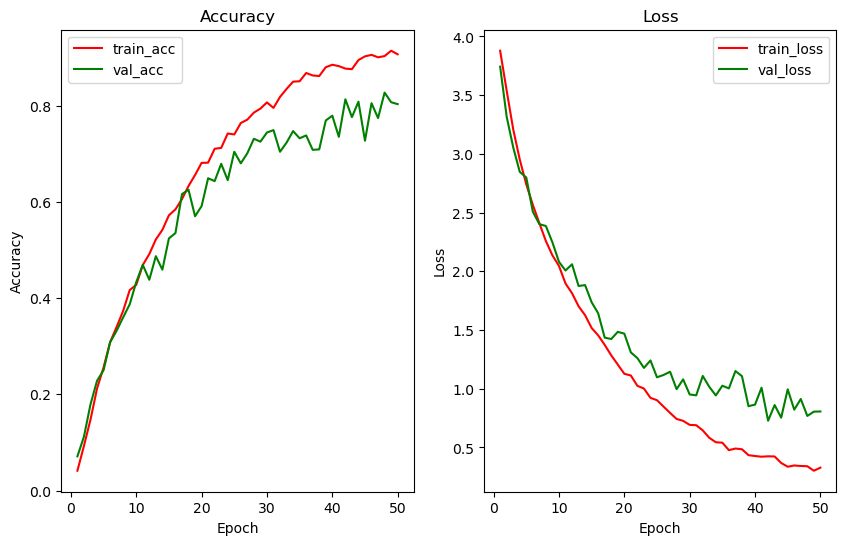

In [19]:
visualize_history(history)

## Test Model

In [21]:
test_loss, test_acc = evaluate(model, weights = last_weights, val_data = test_dataloader, loss_fn = loss_fn, device = 'cuda', verbose = 1)
print(f'Loss: {test_loss : .3f}, Acc: {test_acc: .3f}')

Evaluate: 100%|███████████████████████████████████████████████████| 125/125 [00:43<00:00,  2.89it/s]

Loss:  0.849, Acc:  0.806


In [22]:
test_loss, test_acc = evaluate(model, weights = best_weights, val_data = test_dataloader, loss_fn = loss_fn, device = 'cuda', verbose = 1)
print(f'Loss: {test_loss : .3f}, Acc: {test_acc: .3f}')

Evaluate: 100%|███████████████████████████████████████████████████| 125/125 [00:43<00:00,  2.85it/s]

Loss:  0.749, Acc:  0.836
